# 2. Core concepts
This is the second part of a tutorial introducing core concepts in machine learning using scikit-learn. In this section, we'll define machine learning, review some basic concepts, and cover basic usage of the scikit-learn package, including a number of regression, classification, and clustering examples.

### Stuff we'll need
Before we can do anything else though, let's import all the core tools we're going to use repeatedly throughout this tutorial. For pedagogical purposes, I'll defer importing specific functionality from scikit-learn until the point at which it's actually introduced. That way it'll be clear where everything is coming from.

In [1]:
# the workhorse numerical computing package in Python
import numpy as np

# we've already encountered this specimen
import pandas as pd

# matplotlib is Python's main plotting library.
# the plt module provides high-level access to plots.
import matplotlib.pyplot as plt

# Seaborn is a high-level plotting library. Non-essential,
# but we'll use it to make one or two informative plots.
import seaborn as sns

# A custom plotting function that displays an approximation of the HCP-MMP1
# parcellation in volumetric space. Can also be used to plot coefficients.
from support import plot_hcp_mmp1

/srv/conda/envs/notebook/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## What *is* machine learning?
This is a tutorial about machine learning, so now is probably a good time to explain what we mean by *machine learning*.

Here's a working definition: **machine learning is the field of science/engineering that seeks to build systems capable of learning from experience.**

This is a very broad definition, and in practice, the set of activities that get labeled "machine learning" is pretty heterogeneous. However, two elements are common to nearly all machine learning applications: (a) the emphasis is on developing algorithms that can learn (semi-)autonomously from data, rather than static rule-based systems that must be explicitly designed or updated by humans; and (b) algorithm evaluation focuses heavily on the ability to meet objective quantitative targets.

We can contrast machine learning with traditional scientific inference, where the goal (or at least, *a* goal) is to *understand* or *explain* how a system operates.

The goals of prediction and explanation are not mutually exclusive, of course. But most people tend to favor one over the other to some extent. And, as a rough generalization, people who do machine learning tend to be more interested in figuring out how to make useful predictions than in arriving at a "true", or even just an approximately correct, model of the data-generating process underlying a given phenomenon. By contrast, people interested in explanation might be willing to accept models that don't make the strongest possible predictions (or often, even good ones) so long as those models provide some insight into the mechanisms that seem to underlie the data.

We don't need to take a principled position on the prediction vs. explanation divide here (plenty has been written on the topic; see for example [this paper](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726), [this paper](https://projecteuclid.org/download/pdfview_1/euclid.ss/1294167961), or [this one](https://talyarkoni.org/pdf/Yarkoni_PPS_2017.pdf)). Just be aware that, for purposes of this tutorial, we're going to assume that our goal is mainly to generate good predictions, and that understanding and interpretability are secondary or tertiary on our list of desiderata (though we'll still say something about them now and then).

## Supervised vs. unsupervised learning
Broadly speaking, machine learning can be carved up into two forms of learning: **supervised** and **unsupervised**. We say that learning is supervised whenever we know the true values that our model is trying to predict, and hence, are in a position to "supervise" the learning process by quantifying prediction accuracy and making iterative adjustments. "Ordinary" least-squares regression, in the machine learning context, is an example of supervised learning: our model takes as its input both a vector of *features* (conventionally labeled `X`) and a vector of *labels* (`y`). Researchers often use different terminology in various biomedical and social science disciplines—often calling `X` *variables* or *predictors*, and `y` the *outcome* or *dependent variable*—but the idea is the same.

Here are some examples of supervised learning problems (the first of which we'll attempt later):

* Predicting people's chronological age from structural brain differences
* Determining whether or not incoming email is spam
* Predicting a person's rating of a particular movie based on their ratings of other movies
* Diagnosing schizophrenia based on genetic markers

In each of these cases, we expect to train our model using a dataset where we know the ground truth—i.e., we have *labeled* examples of spam, movie ratings, and schizophrenia diagnosis, in addition to any number of potential features we might use to try and predict each of these labels.

## Supervised learning: classification vs. regression
Within the class of supervised learning problems, we can draw a further distinction between **classification** problems and **regression** problems. In both cases, the goal is to develop a predictive model that recovers the true labels as accurately as possible. The difference between the two lies in the nature of the labels: in classification, the labels are discrete; in regression, they're continuous. 

### Regression
A regression problem arises any time we have a set of continuous numerical labels, and we're interested in using one or more features to try and predict those labels. Any bivariate relationship can be conceptualized as a regression of one variable on the other. For example, suppose we have the data displayed in this scatterplot:

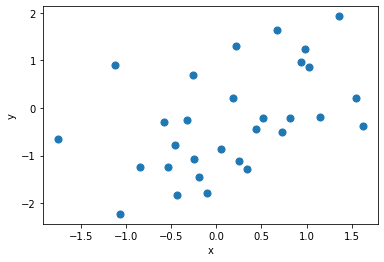

In [2]:
# fix seed to produce deterministic results
np.random.seed(100)

x = np.random.normal(size=30)
y = x * 0.5 + np.random.normal(size=30)

plt.scatter(x, y, s=50)
plt.xlabel('x')
plt.ylabel('y');

We can frame this as a regression problem by saying that our goal is to generate the best possible prediction for `y` given knowledge of `x`. There are many ways to define what constitutes the "best" prediction, but here we'll use the *least-squares* criterion and say we want a model that, when given the `x` scores as inputs, will produce predictions for `y` that minimize the sum of squared deviations between the predicted scores and the true scores.

This is what "ordinary" least-squares (OLS) regression gives us. Here's the OLS solution:

Parameter estimates (intercept and slope): [-0.36822492  0.62140416]


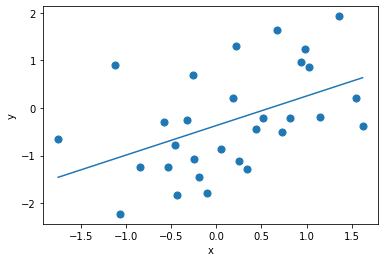

In [3]:
# add intercept
x_with_int = np.hstack((np.ones((len(x), 1)), x[:, None]))
# get least-squares solution
w = np.linalg.lstsq(x_with_int, y, rcond=None)[0]
print("Parameter estimates (intercept and slope):", w)

plt.scatter(x, y, s=50)
plt.xlabel('x')
plt.ylabel('y');

# plot best-fit line
xx = np.linspace(x.min(), x.max()).T
plt.plot(xx, w[0] + w[1] * xx)
np.linalg.lstsq(x[:, None], y, rcond=None);

The linear prediction equation that produces the predicted scores above can be written as $\hat{y} =  -0.37 + 0.62x$. Not every model we use to generate a prediction will be this quite simple. Most won't—either because they have more parameters, or because the prediction can't be expressed as a simple linear combination of the known variables. But what all regression problems share in common with this very simple example is the use of one or more features to try and predict labels that vary continuously.

### Classification
Classification problems are conceptually similar to regression problems. In classification, just like in regression, we're still trying to learn to make the best predictions we can with respect to some target set of labels. The difference is that the labels are now discrete rather than continuous. In the simplest case, the labels are binary: there are only two *classes*. For example, we might have data that look like this:

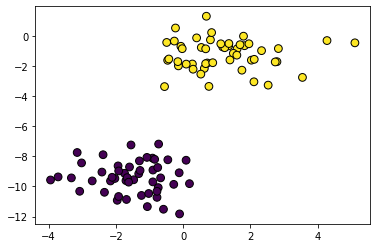

In [4]:
# scikit-learn has some handy utilities for generating structured data
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=2, random_state=2)
plt.scatter(*X.T, c=y, s=60, edgecolor='k', linewidth=1);

Here, we have two features (on the x- and y-axes) we can use to try to correctly *classify* each sample. The two classes are labeled by color.

In the above example, the classification problem is quite trivial: it's clear to the eye that the two classes are perfectly *linearly separable*, so that we can correctly classify 100% of the samples just by drawing a line between them.

Unfortunately, few real-world problems are rarely this simple. If they were, machine learning wouldn't be its own field of study, and employers wouldn't be falling over themselves to pay exorbitant salaries to people who are good at putting circles into boxes of the right color.

Here's what a more realistic classification problem in two dimensions might look like:

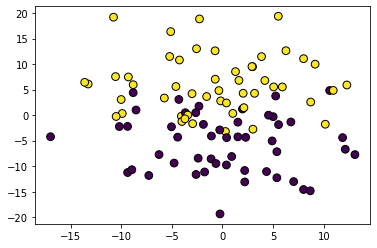

In [5]:
X, y = make_blobs(centers=2, cluster_std=6, random_state=100)
plt.scatter(*X.T, c=y, s=60, edgecolor='k', linewidth=1);

Not so easy now, is it? In fact, it's entirely possible that there's *no* feasible way to perfectly discriminate between the two classes (i.e., even the best possible classifier we could train would always suffer from some degree of misclassification).

Most real-world supervised learning problems—whether they involve regression or classification—have far more than two features we can use to generate predictions, so the complexity of the problem is much greater than the above suggests. Moreover, classification problems aren't restricted to just two classes. For example, we could have a *multiclass* classification problem like this, where our goal is still to correctly label each point, but now there are 5 possible classes:

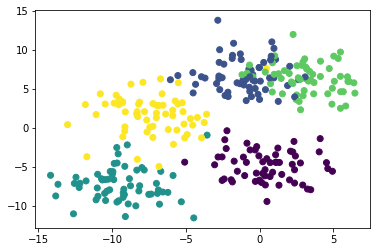

In [6]:
X, y = make_blobs(300, centers=5, cluster_std=2, random_state=100)
plt.scatter(*X.T, c=y);

## Unsupervised learning: clustering and dimensionality reduction
In unsupervised learning, we don't know the ground truth. We have a dataset containing some observations that vary on some set of features `X`, but we're not given any set of accompanying labels `y` we're supposed to predict from `X`. Instead, the goal of unsupervised learning is to find interesting or useful structure in the data. What counts as interesting or useful is of course very much person and context-dependent. But the common denominator is that there is no wrong or right way to organize our samples—or if there is, we don't have access to that knowledge. We're forced to muddle along the best we can, using only the variation in the `X` features to try and make sense of our data in ways that we think might be helpful to us later.

Broadly speaking, we can categorize unsupervised learning applications into two classes: clustering and dimensionality reduction. 

### Clustering
In clustering, our goal is to label the samples we have into discrete *clusters* (or groups). In a sense, clustering is just *classification without ground truth*. In classification, we're trying to recover the class assignments that we know to be there; in clustering, we're trying to make class assignments even though we have no idea what the classes truly are, or even if they exist at all.

The best-case scenario for clustering would be something like this:

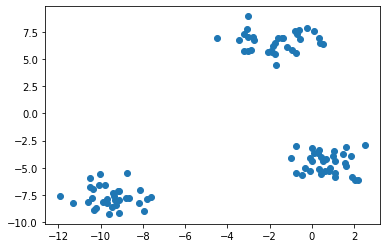

In [7]:
X, y = make_blobs(random_state=100)
plt.scatter(*X.T);

Remember: we don't know the true labels for these observations. So in a sense, any cluster assignment we come up with is just our best guess as to what might going on. Nevertheless, in this particular case, the spatial grouping of the samples in 2 dimensions is so striking that it's hard to imagine us having any confidence in any assignment except the following one:

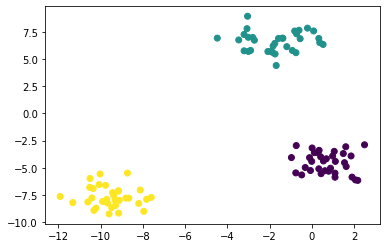

In [8]:
X, y = make_blobs(random_state=100)
plt.scatter(*X.T, c=y);

Unfortunately for us, just as we don't often get super clean classification or regression problems, clustering problems as easy as the one above are rare. A more typical scenario might look something like this:

Text(0.5, 1.0, 'What we see')

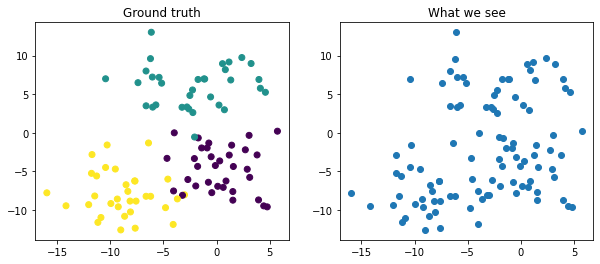

In [9]:
X, _ = make_blobs(centers=3, cluster_std=3, random_state=100)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(*X.T, c=y);
axes[0].set_title("Ground truth")
axes[1].scatter(*X.T);
axes[1].set_title("What we see")

Here, the ground truth is plotted on the left. If we knew the ground truth, we'd have a classification problem—and an easy one at that, because the clusters are almost perfectly linearly separable. But take away the labels, as we do in the right panel, and now it's not so clear at all, is it? In fact, it's not even obvious from the right panel *how many* clusters there are. Recovering the left panel from the right is a difficult problem, even when the true clusters barely overlap! Now imagine how much harder the problem becomes once there's considerable overlap on many of the features, as is more common in the real world.

Worse yet, in the real world, there often *aren't* actually any "true" clusters, and the underlying data-generating process can be described as a continuous function. For example, the distribution we observe in the right panel above could easily have emerged from a bivariate normal distribution—in which case any attempt to discretely label the samples, as in the left panel, would potentially be quite misleading—even if it seemed to make a lot of sense visually!

These kind of complexities are ubiquitous when we're doing clustering (or really any kind of unsupervised learning), and reminding ourselves of them from time to time is useful—and humbling.

### Dimensionality reduction

The other major application of unsupervised learning is *dimensionality reduction*. Here, the idea, just as the name suggests, is to reduce the dimensionality of our data. The reasons why dimensionality reduction is so critical in machine learning won't become fully clear until later sections, when we talk about overfitting. But a general intuition we can build on is that most real-world datasets—especially large ones—can be efficiently described using fewer dimensions than there are nominal features in the dataset. The reason for this is that real-world datasets tend to contain a good deal of structure: variables are related to one another in important (though often non-trivial) ways, and some variables are *redundant* with others, in the sense that they can be redescribed as functions of other variables. The intuition is that, if we can capture most of the variation in the features of a dataset using a smaller subset of those features, we can reduce the effective size of our dataset and build predictions more efficiently.

To illustrate, consider this dataset:

### Dimensionality reduction
The other major application of unsupervised learning is **dimensionality reduction**. Here, the idea, just as the name suggests, is to reduce the dimensionality of our data. The reasons why dimensionality reduction is so critical in machine learning won't become fully clear until later sections, when we talk about overfitting. But a general intuition we can build on is that most real-world datasets—especially large ones—can be efficiently described using fewer dimensions than there are nominal features in the dataset. The reason for this is that real-world datasets tend to contain a good deal of structure: variables are related to one another in important (though often non-trivial) ways, and some variables are *redundant* with others, in the sense that they can be redescribed as functions of other variables. The intuition is that, if we can capture most of the variation in the features of a dataset using a smaller subset of those features, we can reduce the effective size of our dataset and build predictions more efficiently.

To illustrate, consider this dataset:

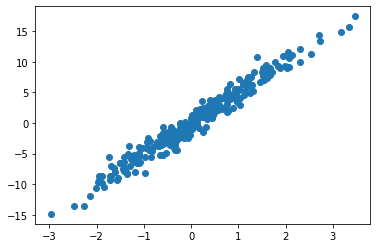

In [10]:
x = np.random.normal(size=300)
y = x * 5 + np.random.normal(size=300)

plt.scatter(x, y);

Nominally, this is a two-dimensional dataset, and we're plotting the two features on the x and y axes, respectively. But it seems clear at a glance that there aren't *really* two dimensions in the data—or at the very least, one dimension is far more important than the other. In this case, we could capture the vast majority of the variance along both dimensions with a single axis placed along the diagonal of the plot—in essence, "rotating" the axes to a "simpler" structure.  If we keep only the first dimension in the new space, and lose the second dimension, we reduce our 2-dimensional dataset to 1 dimension, with very little loss of information.

## The ABIDE II data
Now that we have a qualitative handle on some of the basic kinds of machine learning applications, let's work through a few concrete examples in more detail, using the scikit-learn package. The data we'll be using throughout this notebook, and the ones that follow it, come from the [Autism Brain Imaging Data Exchange II](http://fcon_1000.projects.nitrc.org/indi/abide/abide_II.html) (ABIDE II) project. Background on the project and data was provided in the first notebook in this series, so we'll only briefly revisit them here.

Let's read them in and display the first few rows:

In [11]:
data = pd.read_csv('data/abide2.tsv', sep='\t')

data.head(5)

,site,subject,age,age_resid,sex,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,ABIDEII-KKI_1,29293,8.893151,13.642852,2.0,1.0,2750.0,306.0,354.0,2123.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,ABIDEII-OHSU_1,28997,12.000000,16.081732,2.0,1.0,2836.0,186.0,354.0,2261.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,ABIDEII-GU_1,28845,8.390000,12.866264,1.0,2.0,3394.0,223.0,373.0,2827.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,ABIDEII-NYU_1,29210,8.300000,13.698139,1.0,1.0,3382.0,266.0,422.0,2686.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,ABIDEII-EMC_1,29894,7.772758,14.772459,2.0,2.0,3080.0,161.0,346.0,2105.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


Recall that the dataframe contains 1,004 rows (each one a different human subject), and 1,446 columns. The first 6 columns contain key phenotypic variables—most importantly, **age**, which is measured in years, and diagnosis **group**, where 1 indicates an autism diagnosis, and 2 indicates a control subject. The rest contain 4 sets of structural brain features extracted using the FreeSurfer package, reflecting measures of surface area (`fsArea`), volume (`fsVol`), cortical thickness (`fsCT`), and local gyrification (`fsLGI`).

Each set of FreeSurfer features contains 360 variables, reflecting the 360 regions-of-interest in the Human Connectome Project's MMP1 parcellation. That parcellation looks roughly like this (each color is a different ROI):

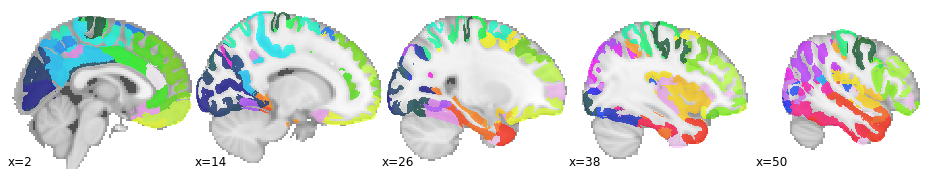

In [12]:
plot_hcp_mmp1(display_mode='x', cut_coords=[2, 14, 26, 38, 50])

## The scikit-learn package
Now that we have some data, let's talk about scikit-learn (often abbreviated `sklearn`), which is the primary package we'll be working with throughout this tutorial. Scikit-learn is the most widely-used machine learning package in Python—and for that matter, probably in any language. Its popularity stems from its simple, elegant interface, [stellar documentation](https://scikit-learn.org/stable/documentation.html), and comprehensive support for many of the most widely used machine learning algorithms (the main exception being deep learning). Scikit-learn provides well-organized, high-quality tools for virtually all aspects of the typical machine learning workflow, including data loading and preprocessing, feature extraction and feature selection, dimensionality reduction, model selection and evaluation, and so on. We'll touch on quite a few of these as we go through the tutorial.

### Data in scikit-learn
Scikit-learn operates almost exclusively on numpy arrays, so that's what it expects to be handed as inputs (though recent builds of scikit-learn are compatible with pandas, so we can usually give scikit-learn objects DFs rather than numpy arrays as inputs, and it'll just extract the numpy arrays underlying those DFs internally).

The structure of the arrays scikit-learn expects to receive is straightforward. The main input to virtually all *estimators* (we'll explain what those are momentarily) is a 2-dimensional array of samples x features—i.e., each row is a different observation, and each column contains a single feature. Conventionally, this array is labeled `X`. Fortunately for us, this is exactly the format our ABIDE data are already in, so there's very little we need to do in order to construct appropriate `X` inputs. Let's just make sure our `X` only contains those features we want our models to learn from. In the examples we'll work through, we'll be using only the structural brain features as our features, so let's make sure `X` contains only those columns.

We'll actually store all these features in an array named `X_all` rather than `X`, as we'll be sub-sampling from `X_all` quite frequently, and this way we'll know that it contains *all* 1,440 features we started out with.

In [13]:
# The filter() method allows us to select variables by name--
# in this case, we put all features that match 'fs' in X_all.
X_all = data.filter(like='fs')

X_all.head()

,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,fsArea_L_V8_ROI,fsArea_L_4_ROI,fsArea_L_3b_ROI,fsArea_L_FEF_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,2750.0,306.0,354.0,2123.0,1451.0,1128.0,269.0,1751.0,1338.0,632.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,2836.0,186.0,354.0,2261.0,1584.0,1241.0,259.0,1521.0,1105.0,302.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,3394.0,223.0,373.0,2827.0,1816.0,1299.0,221.0,1657.0,1374.0,456.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,3382.0,266.0,422.0,2686.0,1893.0,1359.0,234.0,1889.0,1545.0,407.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,3080.0,161.0,346.0,2105.0,1307.0,1004.0,254.0,1334.0,985.0,315.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


For unsupervised learning applications in scikit-learn, the feature data `X` are always we need. But for supervised applications, the features aren't enough; we also need labels—conventionally labeled `y`. Scikit-learn expects `y` to be a 1-dimensional array (or vector).

The variables we use as labels will vary across the applications we work through below, but for the time being, let's start by assigning age to `y`:

In [14]:
# We don't *have* to extract the numpy array with .values;
# scikit-learn will work fine with a pandas Series.
y = data['age'].values

## Regression example: brain-age prediction
Now we're ready to train some models! Let's start with a regression example. We'll try to predict the measured chronological age of subjects in our dataset from variation in their brain features. Let's see how we do that in scikit-learn.

### Estimators in scikit-learn: Basic usage
One of scikit-learn's most attractive features is its unified, simple interface for configuring estimators and fitting models. A good deal of the package consists of a very large set of `Estimator` classes you can use to do various forms of machine learning. In scikit-learn, an `Estimator` does exactly what the word *estimator* normally means in statistics: it implements ["a rule for calculating an estimate of a given quantity based on observed data"](https://en.wikipedia.org/wiki/Estimator).

While scikit-learn includes hundreds of different estimators that generate predictions in very different ways, they all share a common interface (or *API*). In particular, every estimator class implements `.fit()` and `.predict()` methods. When we call an estimator's `.fit()` method, we're telling it to take some training data—including a mandatory `X` matrix, and an optional `y` vector (if it's a supervised estimator)—and do something with it. In cases where `y` is present, the estimator is generally trying to learn how to predict the values of `y` from the values in `X`. Once it's done that, we can then call `predict()`, which takes another `X` matrix (either the same one as before, or a different one) and predicts corresponding `y` scores.

### Applying the LinearRegression() estimator
To see this in action, let's try out one particular estimator in scikit-learn: "ordinary" least-squares (OLS) regression. We'll start out small, by using just a handful of brain features (rather than all 1,440) to generate a prediction. Let's sample, say, 5 features at random from the full set we've stored in `X_all`.

In [15]:
N_FEATURES = 5

# pandas DFs have a helpful sample() method for sampling rows/columns
X = X_all.sample(N_FEATURES, axis=1, random_state=100)

# We did this above, but just to be clear on where y is coming from...
y = data['age'].values

Next, we import and initialize our linear regression estimator. Scikit-learn organizes estimators and other tools into modules based on what they're used for and/or the kind of model they represent. Linear models, including `LinearRegression`, are generally found in the `sklearn.linear_model` module.

In [16]:
# the linear_model modules contains many other linear estimators
from sklearn.linear_model import LinearRegression 

# initialize the estimator
model = LinearRegression()

The `LinearRegression` estimator has relatively few configurable parameters, and for our purposes, the defaults are all fine (e.g., by default, `fit_intercept=True`, so scikit-learn will automatically add an intercept column to our predictor matrix).

#### Fitting the model
Now we're ready to fit our data! As noted above, we do this by calling the `.fit()` method. This is true for every `Estimator` in scikit-learn.

In [17]:
# Fit the model, passing in X and y
model.fit(X, y)

LinearRegression()

Once we execute the above line, we have a fitted model. One thing we can do at this point is examine the estimated model parameters:

In [18]:
# The sklearn convention is to denote fitted parameters with a trailing underscore
print("Estimated intercept:", model.intercept_.round(2))
print("Estimated coefficients:", model.coef_.round(2))

Estimated intercept: 53.81
Estimated coefficients: [-3.94  0.02 -8.92 -0.   -0.01]


Notice that the coefficients vary dramatically in size. This isn't because 2 of them are much more important than the other 3; it's because the 4 sets of FreeSurfer features are on very different scales (e.g., the surface area features have much larger values than the cortical thickness features). Later in the tutorial, we'll explicitly standardize the features so they're all on the same scale. But for now it makes no difference, as the `LinearRegression` estimator is insensitive to scale.

#### Generating predictions
If we want to, we could use the parameter estimates extracted above to explicitly compute predictions for new observations. I.e., we would effectively be applying the following prediction equation:

$$\hat{y} = 53.81 - 3.94x_1 + 0.02x_2 - 8.92x_3 - 0.01x_5$$

But if we just want to generate predicted scores given a set of `X` values (either the same ones we used to train the model, or different ones), we can make use of the `.predict()` method that all supervised scikit-learn estimators implement. For example, here are the predicted scores for our original `X` data:

In [19]:
y_pred = model.predict(X)

y_pred

array([15.69036168, 11.17854891, 16.67486452, ..., 11.42650131,
       10.54443185, 14.57754089])

Let's visualize the predicted scores against the true scores:

/srv/conda/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


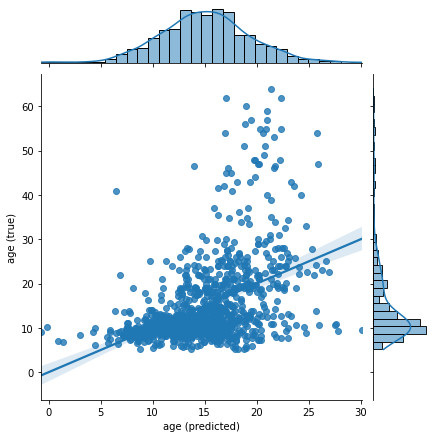

In [20]:
# We're using seaborn, a high-level plotting library that makes it
# extremely easy to generate complex, elegant visualizations.
g = sns.jointplot(y_pred, y, kind="reg").set_axis_labels("age (predicted)", "age (true)")

Two things should jump out at us from this plot. First, the model appears to be capturing at least *some* signal in the data, in that the predicted age values clearly bear some non-trivial relationship to the true values. Second, the relationship is clearly non-linear, suggesting that our model might be misspecified. There are various ways we could potentially address this (e.g., as an exercise, you can try log-transforming age and repeating the estimation), but we won't worry about it here, as our goal is to learn machine learning in scikit-learn, not to produce publishable results.

Anyway, that's it! In just a few lines of code, we've initialized a linear regression model, fitted it using some data, and generated new predicted scores. This basic pattern is common to all estimators in scikit-learn.

Just to underscore how little we had to do, here's the whole example again, in three lines:

In [21]:
# Initialize the linear regression estimator
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Generate predictions
y_pred = model.predict(X)

#### Machine learning is not (usually) about inference over model parameters
Once we've fit our model, we're going to want to see some results. At this point, if you're used to a point-and-click package like SPSS, or a stats-oriented language like R, you might expect to see a big dump of information that includes things like regression coefficient estimates and standard errors, p-values, $R^2$ values, and so on. Well... we're not really going to talk about those things here. We *could* get that kind of information out of other Python packages; for example StatsModels will give you [something very similar](https://www.statsmodels.org/dev/regression.html) to R's `lm` summary):

In [22]:
import statsmodels.api as sm

tmp_X = sm.tools.add_constant(X)
ols = sm.OLS(y, tmp_X)
ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     49.91
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           3.28e-46
Time:                        03:35:34   Log-Likelihood:                -3565.3
No. Observations:                1004   AIC:                             7143.
Df Residuals:                     998   BIC:                             7172.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               53.8130      3.323     16.196      0.000      47.293      60.333
fsCT_R_a24_ROI      -3.9354      0.706     -5.574      0.000      -5.321      -2.550
fsArea_R_d32_ROI     0.0152      0.004      3.888      0.000       0.008       0.023
fsCT_L_PBelt_ROI    -8.9219      1.035     -8.618      0.000     -10.954      -6.890
fsLGI_L_POS2_ROI    -0.0032      0.002     -1.401      0.162      -0.008       0.001
fsVol_L_FOP1_ROI    -0.0122      0.002     -5.976      0.000      -0.016      -0.008
==============================================================================
Omnibus:                      439.100   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2228.847
Skew:                           1.996   Prob(JB):                         0.00
Kurtosis:                       9.111   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

...but that's not really what machine learning (or scikit-learn) is about. Instead, the focus is on prediction. Typically, we have some objective quantitative metric we care about, and to the degree that a model can produce better values on that metric, we incline to evaluate it more favorably. This doesn't mean that we have to single-mindedly base our evaluation of model on just one quantity; in practice, many other considerations may come into play (e.g., computational efficiency, interpretability, etc.). The point is mainly that machine learning practitioners—at least in applied settings—tend to care much more than traditional scientists do about what models can actually do, and much less about what's going on inside them.

### Quantifying performance in scikit-learn: the metrics module
There are many metrics we could use to quantify the quality of the predictions our model generates. Scikit-learn conveniently packages some of the most commonly used performance metrics in its `metrics` module. As is true of `Estimator` objects, all metrics in scikit-learn follow the same usage pattern: we pass in the true scores and the model's predicted scores, respectively.

#### The coefficient of determination ($R^2$)
Let's see how this works using one of the most commonly used metrics in regression problems: the coefficient of determination, or $R^2$, which quantifies the proportion of variance in the outcome variable (e.g., age) explained by the fitted model. Note that $R^2$ is a relative performance metric—i.e., it tells us how well our model captures the observed *variation* in scores, but it's insensitive to the absolute values (i.e., a model can have an $R^2$ of 1 while generating a predicted score distribution entirely outside the range of the true scores). But for our purposes it'll work fine.

Here's how we apply a metric function from `sklearn.metrics`:

In [23]:
# the metrics module contains predefined scoring functions
# for commonly used metrics like r^2, MSE, etc. but you
# can use any function you like as long as it has the
# signature used in the r2_score call below
from sklearn.metrics import r2_score

# Generate predicted values so we can compare them with
# the ground truth.
y_pred = model.predict(X)

# scoring functions are called by passing an array of
# true scores and and an array of predicted scores as
# inputs
r2_score(y, y_pred)

0.2000318750191794

Our fitted linear regression model explains around 20% of the variance in age. Whether this is good or bad is a matter of perspective, but at the very least it's clear that we can non-trivially predict people's ages from a handful of structural brain features.

As an **exercise**, you can try experimenting with other metrics by replacing `r2_score` in the above code with `mean_squared_error`, `mean_absolute_error`, or one of the other predefined metrics. You could even write your own metric function and use it above, as long as it takes the true scores and predicted scores (in that order) as the only arguments.

#### Built-in scoring
For convenience, supervised scikit-learn estimators have a `.score()` method we can use as an alternative to the above. Instead of generating predicted scores and then explicitly feeding them to a metric function like `r2_score`, we can call `.score()` directly on the estimator after the `fit()` step, and the prediction will be done implicitly. The only downside of this approach is that we lose the ability to specify which scoring metric to use; the choice is made for us.

In [24]:
# Initialize the estimator and fit the data, just like before
est = LinearRegression()
est.fit(X, y)
# Now instead of generating predictions explicitly,
# we just call .score(). Note that we lose the ability to
# specify the metric: LinearRegression.score() always uses
# the R^2 metric.
est.score(X, y)

0.2000318750191794

## Classification example: autism classification
Now let's look at classification. In this case, the target labels we're trying to predict are discrete. In general, one can always turn a regression problem into a classification problem by discretizing the data in some way. For example, we could in principle binarize our continuous age variable around the median value, giving us two equal-sized YOUNG and OLD groups. However, discretizing continuous data for classification purposes is almost always [a really bad idea](https://kuscholarworks.ku.edu/bitstream/handle/1808/1495/maccallum_zhang_preacher_rucker_2002.pdf%3Bjsessionid%3DF462A1308B95C63AEBD9AC5E8B689688?sequence%3D1)—and frankly, I'm mainly mentioning that it *can* be done in order to point out that it generally *shouldn't* be done (even though it's an extremely common practice).

Fortunately, we don't need to harm any continuous variables in the making of this notebook. Instead, we'll use a different set of labels: diagnosis group. Recall that ABIDE II is an autism project, and roughly half of the participants in the dataset are diagnosed with autism. So let's see if we can predict autism diagnosis, rather than age, from structural brain features.

To get a very rough qualitative sense of how difficult a problem this is likely to be, we can plot subjects' group status as a function of three of the brain features (visualization in more than 3 dimensions becomes, well, tricky). Full disclosure: these aren't randomly selected features; I've deliberately chosen 3 of the features most strongly correlated with diagnosis. The fact that the correlations are still pretty weak (on the order of r = .15 - .2), and that it's very hard to see any separation in the resulting plot, might lead us to suspect that this is going to be a pretty difficult classification problem.

In [25]:
# 3d plotting
from mpl_toolkits.mplot3d import Axes3D

# Interactive widgets!
from ipywidgets import interact

fs_vars = ['fsLGI_L_OFC_ROI', 'fsLGI_R_STSvp_ROI', 'fsCT_L_10d_ROI']
x, y, z = X_all[fs_vars].values.T
from ipywidgets import interact

def plot_3d_scatter(elev, azim):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, s=20, marker='^', c=data['group'])
    ax.set(xlabel=fs_vars[0], ylabel=fs_vars[1], zlabel=fs_vars[2])
    ax.view_init(elev, azim);

interact(plot_3d_scatter, elev=45, azim=45);

interactive(children=(IntSlider(value=45, description='elev', max=135, min=-45), IntSlider(value=45, descripti…

### Applying classifiers
Okay, let's get on with the actual classification. How do we apply classification estimators in scikit-learn? It's a trick question! We've actually already covered it in the regression example. For the most part, there's very little difference in the way we interact with regression and classification estimators; we just have to be careful not to pass discrete labels to regression estimators, or continuous labels to classification estimators. But mechanically, we construct and fit the models in the same way.

Let's try this out with a *gaussian Naive Bayes* (GNB) classifier. [Gaussian Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Gaussian_na%C3%AFve_Bayes) is a simple classification approach based on a "naive" application of Bayes' Theorem (the naivete stems from the classifier's assumption that all features are independent of one another conditional on class assignment—an assumption that greatly simplifies analysis, though it's nearly always false). It's a good baseline estimator, because it performs surprisingly well in many situations, and is extremely computationally efficient.

Naive Bayes classifiers have no trouble handling large sets of highly correlated features, so we'll just throw everything we have at the classifier, and try to predict diagnosis class from all 1,440 features.

In [26]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

y = data['group']

gnb.fit(X_all, y)

GaussianNB()

### Evaluating classification performance
We already know how to obtain a performance estimate from the built-in scorer, so let's do that:

In [27]:
gnb.score(X_all, y)

0.6254980079681275

In this case, the default scoring metric is just overall accuracy (i.e., the proportion of all samples that were assigned to the correct class). Is 63% accuracy good or bad? As always, it depends. It's obviously nowhere near good enough to be useful in practical applications, but on the other hand, it's clearly better than randomly guessing.

#### Classification reports
The raw accuracy score is a good place to start, but it often masks important nuances. We can get some more information using the `classification_report` utility, which breaks down classification performance into separate `precision` (aka positive predictive value), `recall` (aka sensitivity), and `f1` scores (we can also get these individually from the `sklearn.metrics` module, as well as a number of other useful utilities).

In [28]:
from sklearn.metrics import classification_report

y_pred = gnb.predict(X_all)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         1.0       0.63      0.44      0.52       463
         2.0       0.62      0.78      0.69       541

    accuracy                           0.63      1004
   macro avg       0.63      0.61      0.61      1004
weighted avg       0.63      0.63      0.61      1004



Notice that while the precision is almost identical for the two groups, the recall (or sensitivity) differs substantially: control subjects have a higher probability (78%) of being correctly labeled than do subjects with an autism diagnosis (44%). Can you think of an explanation for this pattern?

## Clustering example: are there neural subtype of autism?
Recall that clustering is a form of unsupervised learning where we seek to assign our observations to discrete clusters in the absence of any knowledge of the ground truth (if there is one). Clustering applications are common in psychiatry and psychiatric imaging, as researchers often want to determine whether, e.g., patients with a particular diagnosis appear to cluster into somewhat distinct subtypes—with potential implications for prognosis, treatment, etc.

We can ask this question with respect to the ABIDE data we have available. If we take only those subjects with an autism diagnosis, can we cluster subjects into discrete subtypes based on differences in the brain features we have available?

At this point it probably won't surprise you to hear that scikit-learn contains implementations of quite a few popular clustering algorithms. Clustering estimators in sklearn are located, as you might intuit, in the `sklearn.cluster` module. We'll focus our attention on what is arguably the most widely used clustering algorithm, namely, *k*-means. In *k*-means clustering, we assign samples to *k* discrete clusters in such a way as to minimize the distance from each observation to the centroid of the cluster it belongs to, and maximize the distance between the cluster centroids. We won't get into the [details of the k-means algorithm](https://en.wikipedia.org/wiki/K-means_clustering) here; instead, we'll simply demonstrate how we'd go about running a cluster analysis with scikit-learn. As you might expect by now, our code will look a lot like it did for regression and classification.

In principle, we could use all 1,440 features if we wanted to (though computation would likely be slow). But the unsupervised nature of clustering means that evaluating clustering solutions in high dimensions can be quite difficult. So let's focus on clustering observations in just 2 dimensions, and if after that you want to crank up the number of features, you can easily do that.

These first few lines of code are just to get our `X` data: we select only the subjects with an autism diagnosis; then we randomly sample two of our brain features; lastly, we standardize those features to ensure that the k-means algorithm weights them approximately equally (*k*-means computes distances between observations in euclidian space, so differences in scale will bias the clustering).

In [29]:
# the preprocessing module contains a bunch of useful utilities.
# in this case we're going to standardize our columns (i.e.,
# to transform them so they have a mean of 0 and variance of 1).
from sklearn.preprocessing import scale

# feel free to change this
N_FEATURES = 2

# identify indices of the subjects with autism
aut_grp = data['group'] == 1

# get 2 random brain features. note that the random_state is
# fixed; remove it to re-randomize each time.
dx_1 = X_all[aut_grp].sample(2, axis=1)

# save selected column names for display later
columns = dx_1.columns

# standardize columns, otherwise k-means will likely
# weight one feature much more than the other
dx_1 = scale(dx_1)

The actual clustering is, as usual, just a couple of lines of code:

In [30]:
# We'll use KMeans here, but feel free to experiment with
# others—though note that many of the implemented clustering
# algorithms will be very slow if you crank up the number
# of features.
from sklearn.cluster import KMeans

# We have to stipulate the number of features in advance
K = 4

# Initialize the estimator
km = KMeans(K)

# Fit and predict in one shot
clusters = km.fit_predict(dx_1)

Notice that the only real difference between the above code and our earlier regression/classification examples is that we're no longer passing in a `y` array of labels—because there isn't one! We're just trying to find meaningful structure in the data, with no access to any ground truth.

Also notice that we need to specify the number of clusters *k* ourselves. There are literally hundreds of methods people have developed to try to identify the "optimal" value of *k*, and some of them are included in the `sklearn.metrics` module. But for our purposes, let's just focus on the solution we get for $k = 4$. 

Observe that the `clusters` array we get back by calling `.predict()` on a clustering estimator gives us the assigned cluster labels for each observation (indexing from 0 for the first cluster):

In [31]:
clusters

array([0, 1, 1, 3, 0, 2, 1, 0, 1, 1, 1, 0, 2, 0, 3, 3, 0, 1, 3, 1, 3, 2,
       1, 3, 3, 0, 2, 3, 2, 0, 0, 1, 2, 2, 1, 2, 1, 2, 0, 0, 0, 0, 1, 2,
       2, 0, 2, 2, 3, 1, 0, 0, 1, 0, 3, 1, 2, 3, 2, 3, 2, 0, 2, 3, 3, 1,
       0, 1, 1, 0, 3, 1, 3, 0, 1, 3, 3, 1, 0, 0, 3, 2, 1, 3, 0, 1, 2, 2,
       1, 1, 0, 3, 2, 0, 1, 0, 1, 3, 0, 2, 1, 1, 2, 2, 1, 1, 1, 1, 3, 0,
       1, 3, 2, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2, 0, 1, 2, 0, 3, 1, 2, 2,
       0, 0, 0, 3, 0, 0, 1, 0, 3, 1, 0, 1, 1, 2, 0, 2, 1, 3, 1, 3, 2, 3,
       0, 2, 1, 1, 0, 1, 3, 1, 1, 0, 2, 1, 1, 0, 1, 3, 0, 3, 0, 2, 0, 1,
       0, 0, 1, 0, 1, 0, 3, 3, 0, 1, 1, 0, 2, 0, 0, 0, 1, 1, 3, 0, 3, 2,
       2, 1, 1, 0, 2, 0, 3, 0, 2, 0, 3, 1, 0, 1, 3, 1, 1, 2, 0, 3, 3, 0,
       2, 1, 1, 1, 2, 1, 1, 1, 3, 0, 0, 3, 2, 0, 3, 1, 2, 0, 2, 0, 1, 1,
       2, 0, 0, 2, 0, 3, 3, 2, 1, 3, 0, 2, 1, 0, 1, 0, 0, 3, 3, 0, 2, 1,
       0, 1, 1, 0, 1, 3, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2,
       2, 0, 0, 1, 3, 0, 0, 0, 1, 2, 2, 3, 0, 2, 1,

Since we only used two features to do our clustering, we can easily visualize the results of the clustering:

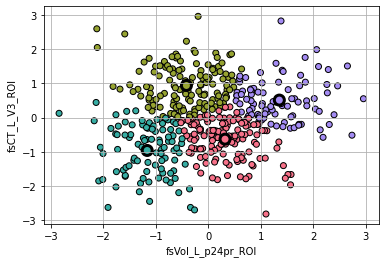

In [32]:
# get nice colors from seaborn
palette = sns.husl_palette(K)
colors = [palette[c] for c in clusters]

# plot labeled 
plt.scatter(dx_1[:, 0], dx_1[:, 1], c=colors, edgecolor='k')

# add cluster centers in black
plt.scatter(*km.cluster_centers_.T, c=palette, edgecolor='k', linewidth=3, s=100)
plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.grid(None)

The clustering *looks* reasonable to the eye... but how far should we trust it? And how should we think about these cluster labels? Are they merely convenient descriptions of the data that facilitate exploration of differences between subgroups of participants, or do we think we're gaining deep insights into the "true" neural bases of different subtypes of autism?

## Job well done?
At this point, let's sit back and assess our progress. We've developed three fully operational machine learning workflows: one for regression, one for classification, and one for clustering. Thanks to scikit-learn, all three involved very little work. In each case, it took only a few lines of code to initialize a model, fit it to some data, and use it to generate predictions or clustering labels. This all seems pretty great. Maybe we should just stop here, pat ourselves on the back for a job well done, and head home for the day satisfied in the knowledge we've become proficient machine learners.

While a brief pat on the back does seem appropriate, we probably shouldn't be *too* pleased with ourselves. We've learned some important concepts in machine learning, explored the basic mechanics of scikit-learn estimators, and applied our knowledge to a few representative problems dealing with neuroimaging data. But as the saying goes, a little bit of knowledge can be a dangerous thing. We haven't yet touched on are a number of concepts and techniques that are absolutely critical if we want to avoid going off the rails with the skills we've just acquired. And going off the rails is surprisingly easy.

To illustrate just *how* easy, let's return to our brain-age regression example. Recall that when we fitted our linear regression model in an effort to predict age from our brain features, we sub-sampled only a small number of features (5, to be exact). As we saw, even with just 5 features, our model was able to capture a non-trivial fraction of the variance in age—about 20%. Intuitively, you might find yourself thinking something like this: *if we can do that well with just 5 randomly-selected features, imagine how well we can do with more features!* And you might want to go back to the middle of this notebook (if you haven't already) and replace the `N_FEATURES` variable with some larger number, re-run the relevant cells, and see how well you do.

I'll save you the trip back up there; we'll do this systematically. Let's re-fit our linear regression model with random feature subsets of different sizes and see what effect that has on performance.

In [33]:
# Loop over these feature set sizes
n_feats = [5, 10, 20, 50, 100, 200, 500, 1000, 1440]

# 10 iterations per set size, for stability
n_iters = 10

# Initialize a placeholder array for the results
results = np.zeros((len(n_feats), n_iters))

# Same target for all fits
y = data['age']

model = LinearRegression()

# Loop over feature set sizes and iterations,
# sample features, fit model, and save score
for i, n in enumerate(n_feats):
    for j in range(n_iters):
        X = X_all.sample(n, axis=1)
        model.fit(X, y)
        results[i, j] = model.score(X, y)

That shouldn't take very long. Once it's done, we can plot the results like this:

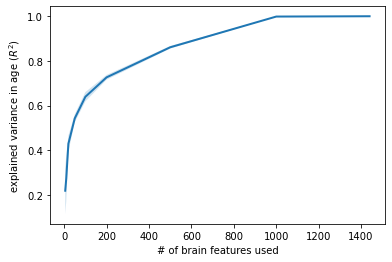

In [34]:
# Average over iterations
means = results.mean(1)

# Plot the performance curve
plt.plot(n_feats, means, linewidth=2)

# Add standard 1 sd error bars—though they're so small it's
# hard to see them.
stds = results.std(1)
plt.fill_between(n_feats, means - stds, means + stds, alpha=0.2)

plt.xlabel("# of brain features used")
plt.ylabel("explained variance in age ($R^2$)");

At first glance, this might look great: performance improves rapidly with the number of features, and by the time we're sampling 1,000 features, we can predict age perfectly! But a truism in machine learning (and also science, and also daily life) is that if something seems to good to be true, it probably is.

In this case, a bit of reflection on the fact that our model is able predict age with zero error should set off all kinds of alarm bells in our heads, because on any reasonable understanding of how the world works, such a thing should be impossible.

Set aside the brain data for a moment and just think about the problem of measuring chronological age. Is it plausible to think that, in a sample of over 1,000 people, including many young children and older adults, not a single person's age is measured with even the slightest bit of error? Remember, *any* measurement error should reduce our linear regression model's performance, because measurement error is irreducible. If an ABIDE-II participant's birth date happened to be recorded as 1971 when it's actually 1961 (oops, typo!), it's not as if our linear regression model can somehow learn to go back in time and adjust for that error.

Then think about the complexity of the brain-derived features we're using; how well (or poorly) *those* features are measured/extracted; how simple our linear regression model is; and how much opportunity there is for all kinds of data quality problems to arise (is it plausible to think that all subjects' scans are of good enough quality to extract near-perfect features?). If you spend a couple of minutes thinking along these lines, it should become very clear that an $R^2$ of 1.0 for a problem like this is just not remotely believable.

Clearly, there must be something very wrong with our model. And there is: our model is *overfitting* our data. Because we have a lot of features to work with, and not enough samples, our linear regression model is, in a sense getting creative: it's finding all kinds of patterns in the data that look like they're there, but aren't really there. In a word, our model is starting to hallucinate.

If you find the idea that a statistical model could hallucinate kind of perplexing, you might enjoy the next section.